In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli

import qiskit.quantum_info as qi
import numpy as np
import pandas as pd

from qiskit import BasicAer
from qiskit.quantum_info import process_fidelity

from qiskit.extensions import RXGate, XGate, CXGate

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [2]:
# Graph
import networkx as nx

def graph_maker(n, G_i):
    nnodes = n
    # create graph objects
    G_comp = nx.complete_graph(nnodes)
    G_star = nx.star_graph(nnodes-1)
    G_bp = nx.complete_bipartite_graph(nnodes//2,nnodes//2)

    G_set = [G_bp, G_star, G_comp]
    G = G_set[G_i]
    # illustrate graph
    nx.draw(G, with_labels=True, node_color = 'green', node_size = 500)
    
    return G

#g_sample = graph_maker(6,0)

#print(g_sample)

In [3]:
# MaxCut Objective
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1

    return obj

In [4]:
# Expectation Value
def compute_expectation(counts, G):
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
    
    #print(f'Expected objective value is : {avg/sum_count}')
    #obj_list.append(avg/sum_count)
    
    return avg/sum_count

In [5]:
# QAOA put together
# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    global vN, iter_num, schmidt
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
    
    #psi_AB = qi.Statevector.from_instruction(qc)
    #psi_AB.draw('latex', prefix='|\\psi_{AB}\\rangle = ')
    rho_AB = qi.DensityMatrix.from_instruction(qc)
    #rho_AB.draw('latex', prefix='\\rho_{AB} = ')
    #print(f'The density matrix associated with this circuit is {rho_AB}')
    rho_A = qi.partial_trace(rho_AB,[i for i in range(0, nqubits//2)])
    vN_A = qi.entropy(rho_A)
    
    vN.append(vN_A)
    schmidt = np.linalg.matrix_rank(rho_A)
    iter_num += 1
    
    #print(f'The bipartite von Neumann entropy is : {vN_A}')
        
    #print(f'This is the {iter_num}th iteration of QAOA')
    #print(vN)

    qc.measure_all()
                    
    #print(qc)

    return qc

In [6]:
# Running the circuit
# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, shots=2048):
        
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=2048).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 0.8114858475726201.
It ranged from 0.02238273411790983 to 1.4063271952483625,with a mean of 0.812286872306336and a standard deviation of 0.31631734030789577.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [ 0.27386881 -0.25638493].
The total number of iterations required : 32.


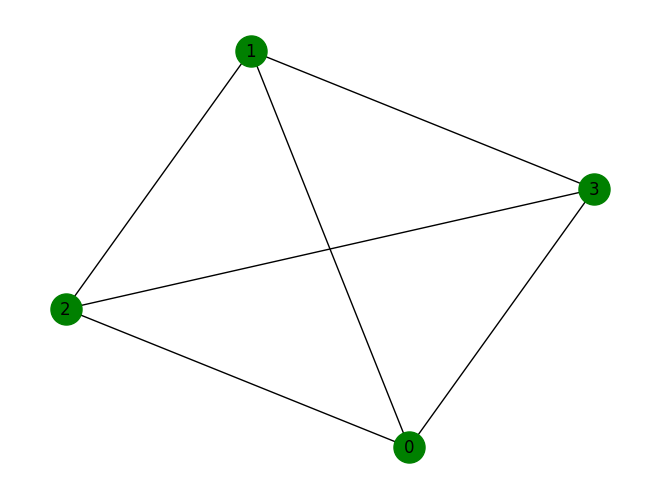

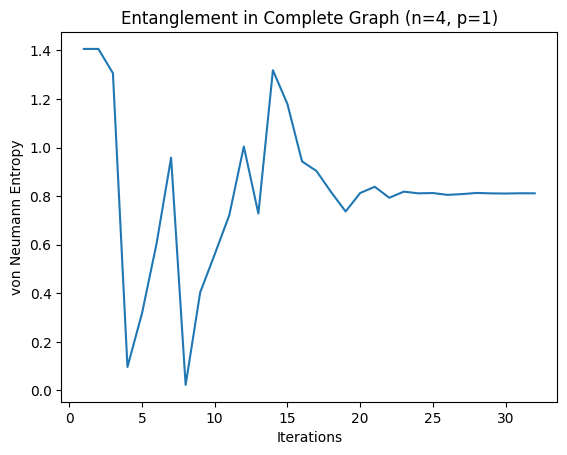

The expectation value of the cut is : 3.6923828125.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 1 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.2410884586647335.
It ranged from 0.648337935049995 to 1.5018040762516167,with a mean of 1.1777525209326016and a standard deviation of 0.1541726274397403.
The initial parameters were : [1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.09149094 0.79891856 1.11266271 0.89310857].
The total number of iterations required : 50.


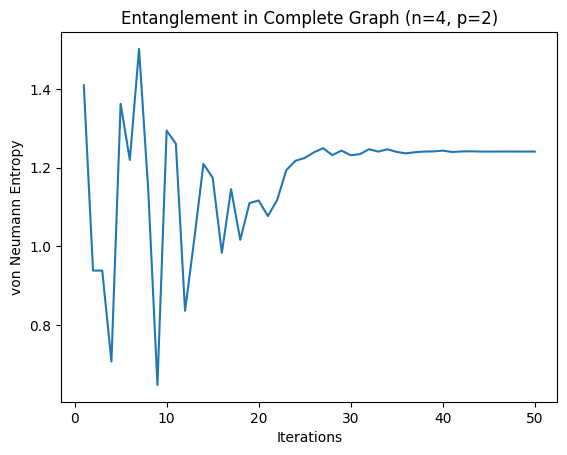

The expectation value of the cut is : 3.9794921875.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 2 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.2462554977907199.
It ranged from 0.03886301344349606 to 1.5376416775578632,with a mean of 1.173037147412776and a standard deviation of 0.26274546450023467.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.71587711 0.11419415 0.94376428 1.07077538 0.80323479 0.8382843 ].
The total number of iterations required : 61.


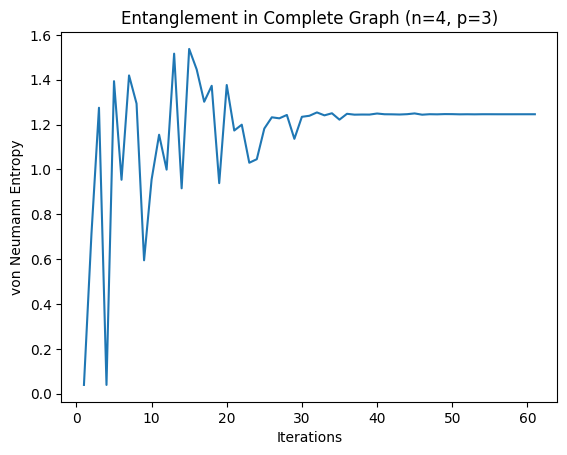

The expectation value of the cut is : 3.9970703125.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 3 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 4 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.206618192242327.
It ranged from 0.496210998050624 to 1.5433840120229092,with a mean of 1.2019055556549747and a standard deviation of 0.13478383604160932.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.75972825 2.111515   0.85796159 1.0435874  0.64876702 2.26520367
 0.46344658 0.33879382].
The total number of iterations required : 87.


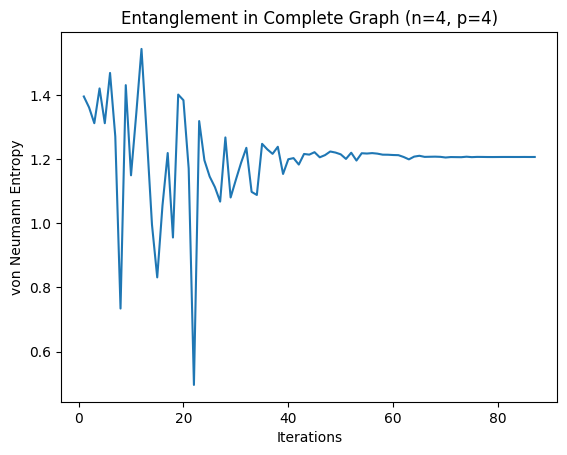

The expectation value of the cut is : 3.984375.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 4 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.250669579487547.
It ranged from 0.5470154878313174 to 1.5174684918036865,with a mean of 1.1748478971427028and a standard deviation of 0.17107290945795034.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.02144853 0.89897828 1.11646513 0.97758262 1.01384944 1.09114274
 0.83603749 1.96322956 0.90206152 1.00734027].
The total number of iterations required : 102.


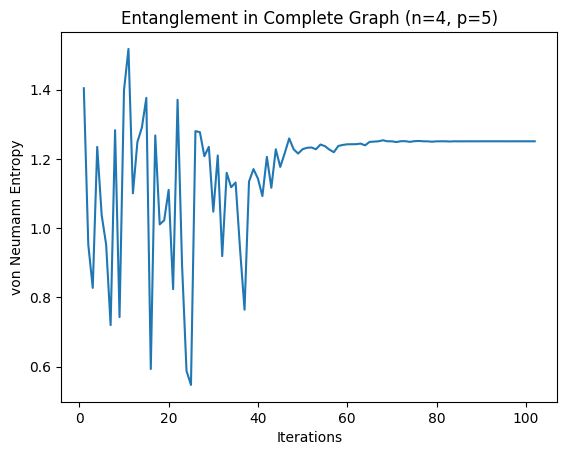

The expectation value of the cut is : 3.9990234375.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 5 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 6 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.250292276213979.
It ranged from 0.04934907629151564 to 1.481657568983402,with a mean of 1.1468184641928598and a standard deviation of 0.2733027344698386.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.0289544  1.03007224 0.98157442 1.03814677 1.09606704 0.71174688
 1.1978705  1.03420807 0.9771755  1.09133268 0.92729498 0.9233545 ].
The total number of iterations required : 132.


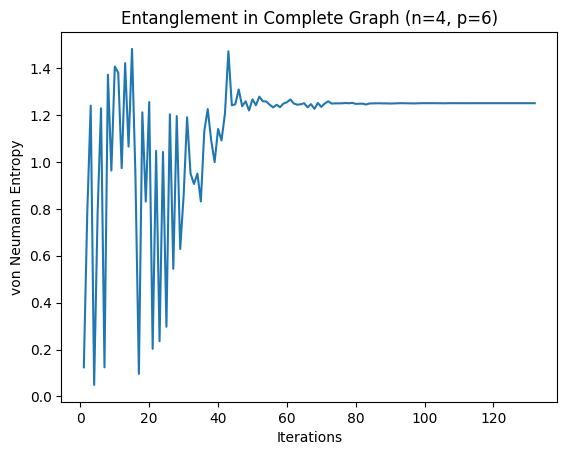

The expectation value of the cut is : 3.9814453125.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 6 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 7 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.251669364912483.
It ranged from 0.3945843297217113 to 1.5832224781568762,with a mean of 1.1951435036773375and a standard deviation of 0.17522780594533227.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.94779499 2.08783178 0.99892567 0.84420703 0.92563111 1.16290932
 2.30313276 1.08312494 1.00160264 0.88670185 1.01091273 0.9527856
 1.95789341 1.95842028].
The total number of iterations required : 127.


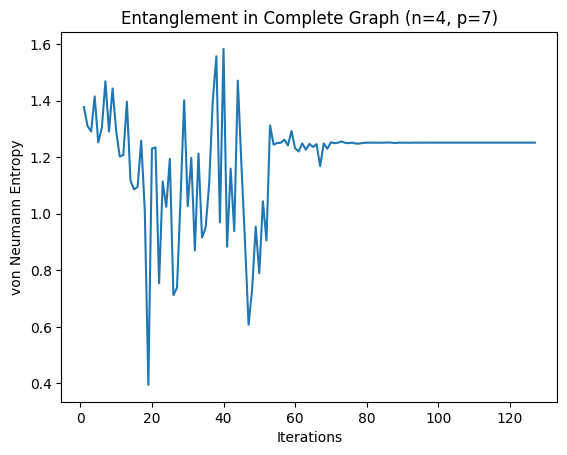

The expectation value of the cut is : 4.0.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 7 layer analysis--
For a Complete Graph with 4 nodes/qubits and a QAOA circuit with 8 layers:
The Schmidt number is : 3.
The final von Neumann entropy is : 1.2511771667768488.
It ranged from 0.5967486509623638 to 1.5567038647714941,with a mean of 1.2032746866307507and a standard deviation of 0.1291506996066402.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.88697336 1.00993252 1.31460581 1.14472777 0.80970761 0.94071308
 0.91425457 0.92025624 0.95889828 1.02175675 1.91158378 0.98774881
 0.97519891 1.07293637 1.04254776 0.97899366].
The total number of iterations required : 169.


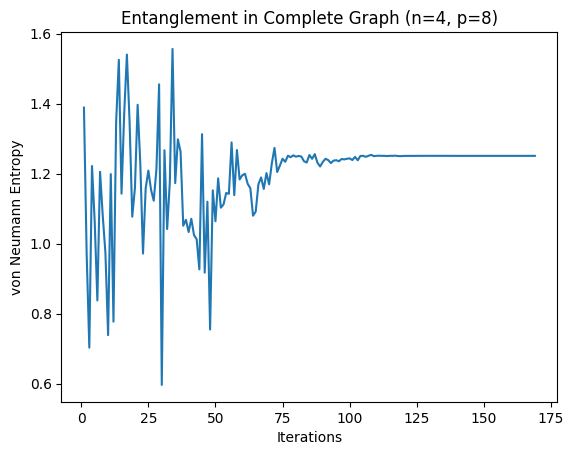

The expectation value of the cut is : 4.0.
The solutions are : 0011, 0101, 0110, 1001, 1010, 1100 with a MaxCut = 4.
--End of 8 layer analysis--


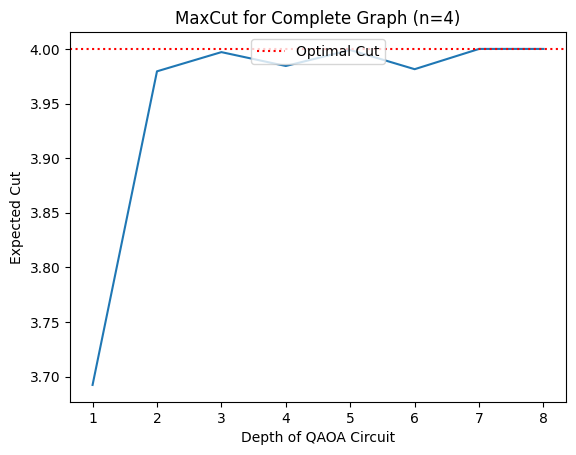

--End of 4 qubit analysis--
For a Complete Graph with 6 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 0.880631649407744.
It ranged from 0.014326664229098531 to 1.6476286017062791,with a mean of 1.0663813821391819and a standard deviation of 0.3690203940659728.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [1.28810279 1.3874883 ].
The total number of iterations required : 33.


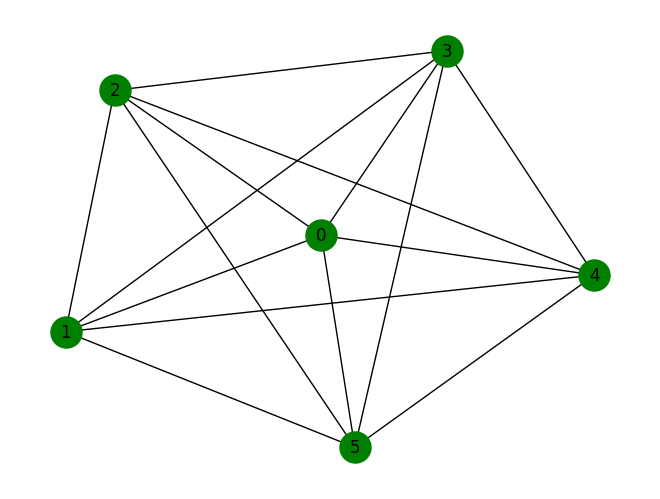

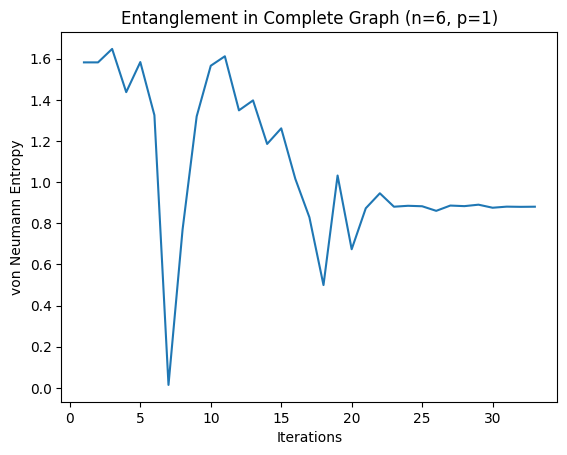

The expectation value of the cut is : 8.595703125.
The solutions are : 000111, 001011, 001101, 001110, 010011, 010101, 010110, 011001, 011010, 011100, 100011, 100101, 100110, 101001, 101010, 101100, 110001, 110010, 110100, 111000 with a MaxCut = 9.
--End of 1 layer analysis--
For a Complete Graph with 6 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.1526040637982569.
It ranged from 0.8007855763645715 to 1.71409176447456,with a mean of 1.2390228106184042and a standard deviation of 0.20322428970512874.
The initial parameters were : [1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.10094404 2.00253212 0.96404175 2.00367009].
The total number of iterations required : 45.


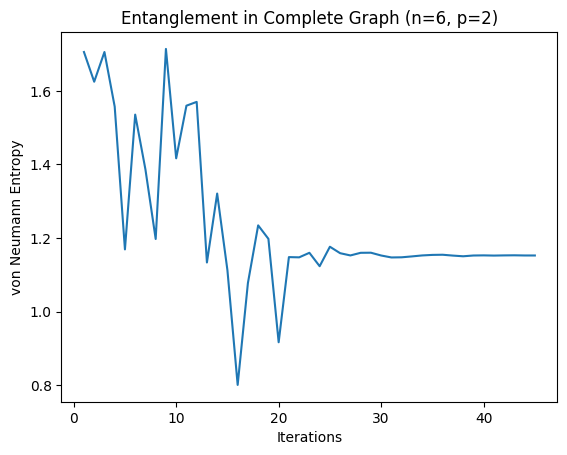

The expectation value of the cut is : 8.404296875.
The solutions are : 000111, 001011, 001101, 001110, 010011, 010101, 010110, 011001, 011010, 011100, 100011, 100101, 100110, 101001, 101010, 101100, 110001, 110010, 110100, 111000 with a MaxCut = 9.
--End of 2 layer analysis--
For a Complete Graph with 6 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.412215748771945.
It ranged from 0.31845525508232336 to 1.8020692530319933,with a mean of 1.38712280127838and a standard deviation of 0.22995564532230317.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.14274878 2.09757842 1.1269545  0.94222728 1.04225858 1.0374031 ].
The total number of iterations required : 79.


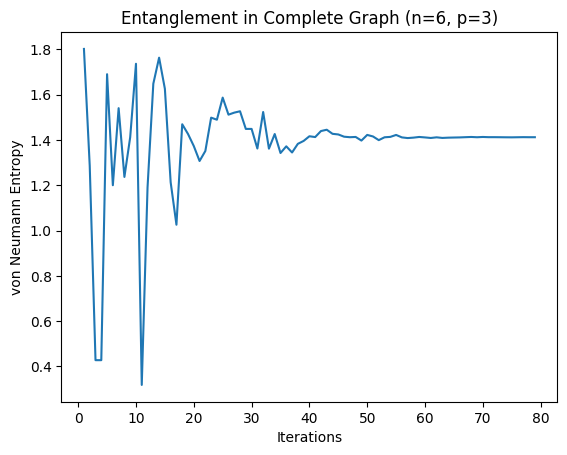

The expectation value of the cut is : 8.966796875.
The solutions are : 000111, 001011, 001101, 001110, 010011, 010101, 010110, 011001, 011010, 011100, 100011, 100101, 100110, 101001, 101010, 101100, 110001, 110010, 110100, 111000 with a MaxCut = 9.
--End of 3 layer analysis--
For a Complete Graph with 6 nodes/qubits and a QAOA circuit with 4 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.4523014423471976.
It ranged from 1.0163895906186735 to 1.8010919474909275,with a mean of 1.4358676738790495and a standard deviation of 0.11753605573989567.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [2.28367287 0.69919661 0.48771075 0.69738194 0.21515268 0.69553101
 0.93077898 0.78493932].
The total number of iterations required : 95.


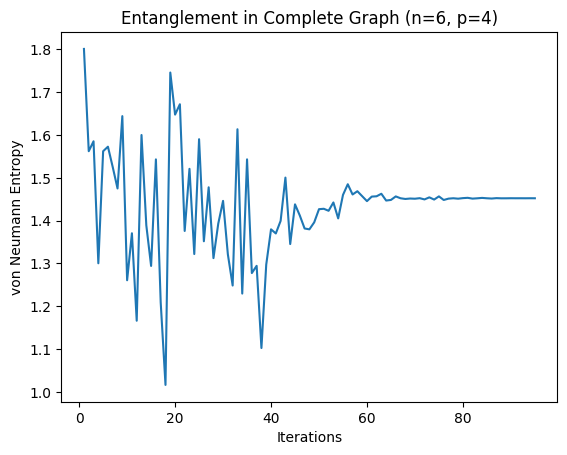

The expectation value of the cut is : 8.984375.
The solutions are : 000111, 001011, 001101, 001110, 010011, 010101, 010110, 011001, 011010, 011100, 100011, 100101, 100110, 101001, 101010, 101100, 110001, 110010, 110100, 111000 with a MaxCut = 9.
--End of 4 layer analysis--
For a Complete Graph with 6 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 0.8339868298843413.
It ranged from 0.8141647520017276 to 1.8780384325460435,with a mean of 1.037765156651728and a standard deviation of 0.2779100485356779.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.45483593 0.98680256 0.95710172 0.97954488 0.94280016 0.95131902
 0.97748825 1.99553265 0.99661208 0.94500643].
The total number of iterations required : 110.


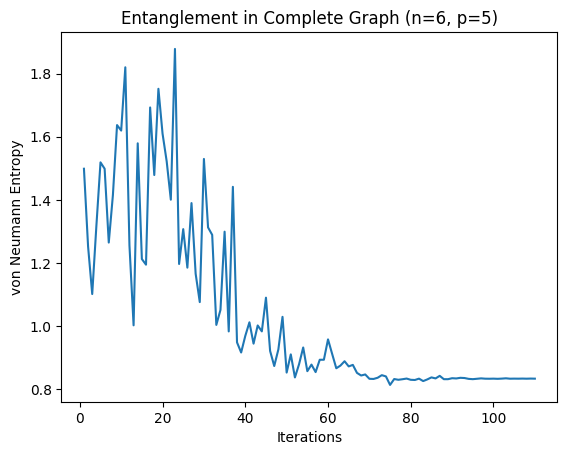

The expectation value of the cut is : 8.34375.
The solutions are : 000011, 000101, 000110, 001001, 001010, 001100, 001111, 010001, 010010, 010100, 010111, 011000, 011011, 011101, 011110, 100001, 100010, 100100, 100111, 101000, 101011, 101101, 101110, 110000, 110011, 110101, 110110, 111001, 111010, 111100 with a MaxCut = 8.
--End of 5 layer analysis--
For a Complete Graph with 6 nodes/qubits and a QAOA circuit with 6 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.441162303891286.
It ranged from 0.971728405856977 to 1.8666151079112214,with a mean of 1.4511104939738875and a standard deviation of 0.13551535373653753.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.96318986 0.98719081 0.97598354 1.00776106 1.00650022 1.05038148
 0.96632676 1.96423049 0.97692798 1.060855   1.01443889 1.03161886].
The total number of iterations required : 128.


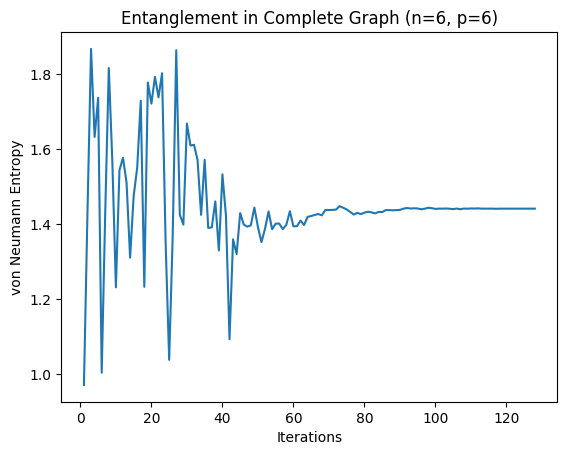

The expectation value of the cut is : 8.986328125.
The solutions are : 000111, 001011, 001101, 001110, 010011, 010101, 010110, 011001, 011010, 011100, 100011, 100101, 100110, 101001, 101010, 101100, 110001, 110010, 110100, 111000 with a MaxCut = 9.
--End of 6 layer analysis--
For a Complete Graph with 6 nodes/qubits and a QAOA circuit with 7 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.2522093923728115.
It ranged from 0.8424238486507799 to 1.8681505644290481,with a mean of 1.2930318930878988and a standard deviation of 0.16502436325165912.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [1.07669501 0.95553505 1.97893802 1.00668765 0.89971585 1.02226703
 0.87037944 1.01362825 1.0036664  2.04317067 0.81002707 0.9220404
 0.96312116 0.99284016].
The total number of iterations required : 172.


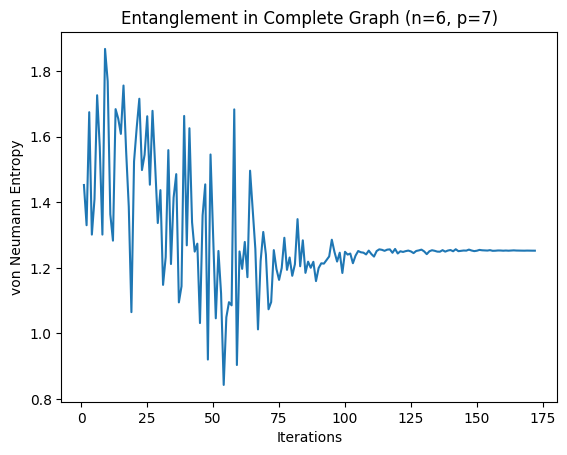

The expectation value of the cut is : 8.8828125.
The solutions are : 000111, 001011, 001101, 001110, 010011, 010101, 010110, 011001, 011010, 011100, 100011, 100101, 100110, 101001, 101010, 101100, 110001, 110010, 110100, 111000 with a MaxCut = 9.
--End of 7 layer analysis--
For a Complete Graph with 6 nodes/qubits and a QAOA circuit with 8 layers:
The Schmidt number is : 4.
The final von Neumann entropy is : 1.4535897477323856.
It ranged from 0.6892502076467013 to 1.8699917883297459,with a mean of 1.4560594752697045and a standard deviation of 0.13591808156202834.
The initial parameters were : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0].
The optimized parameters are : [0.88542621 0.95348326 0.95071522 1.09005311 1.05903898 0.91020979
 0.99770481 2.08126593 1.16900262 2.03525802 0.96766747 0.88531974
 0.97878498 1.20962414 1.12180056 0.9671692 ].
The total number of iterations required : 156.


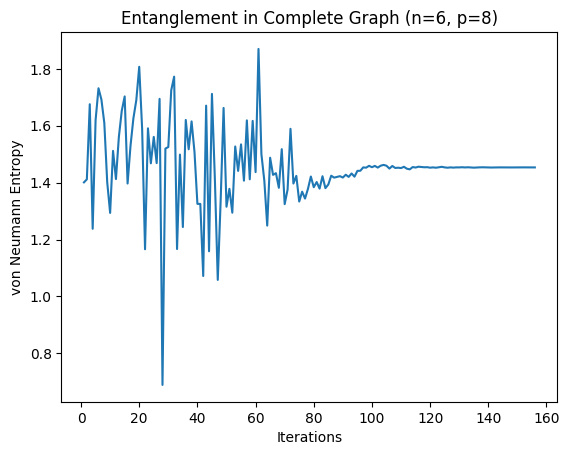

The expectation value of the cut is : 8.9619140625.
The solutions are : 000111, 001011, 001101, 001110, 010011, 010101, 010110, 011001, 011010, 011100, 100011, 100101, 100110, 101001, 101010, 101100, 110001, 110010, 110100, 111000 with a MaxCut = 9.
--End of 8 layer analysis--


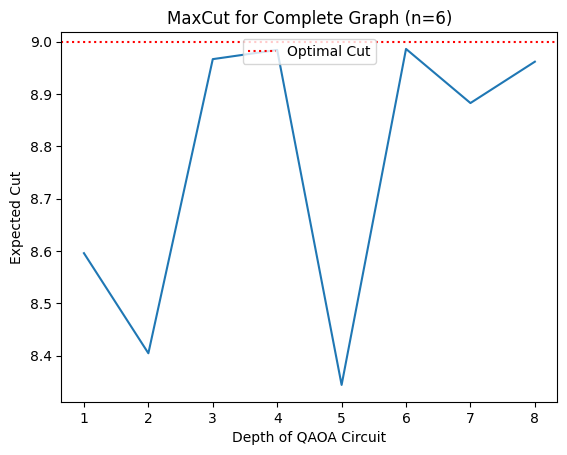

--End of 6 qubit analysis--
For a Complete Graph with 8 nodes/qubits and a QAOA circuit with 1 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.113999236726101.
It ranged from 1.0694032672787308 to 1.823829890999936,with a mean of 1.2830452229029863and a standard deviation of 0.2616700620826345.
The initial parameters were : [1.0, 1.0].
The optimized parameters are : [3.29811135 2.38724614].
The total number of iterations required : 36.


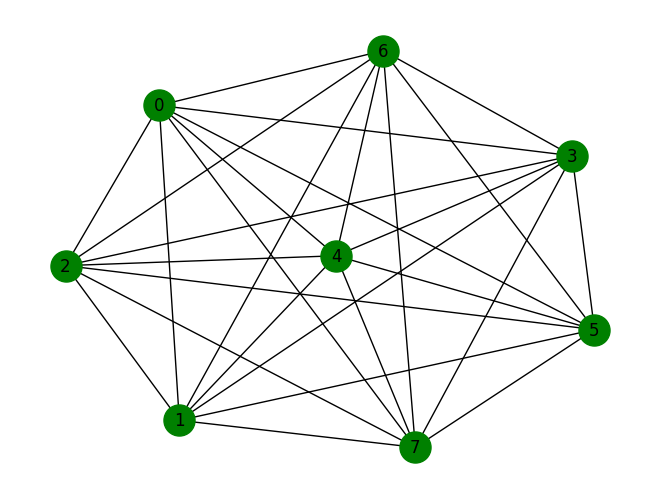

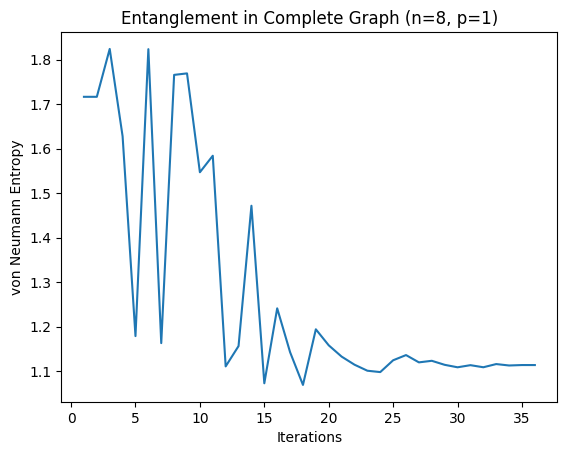

The expectation value of the cut is : 14.1005859375.
The solutions are : 00001111, 00010111, 00011011, 00011101, 00011110, 00100111, 00101011, 00101101, 00101110, 00110011, 00110101, 00110110, 00111001, 00111010, 00111100, 01000111, 01001011, 01001101, 01001110, 01010011, 01010101, 01010110, 01011001, 01011010, 01011100, 01100011, 01100101, 01100110, 01101001, 01101010, 01101100, 01110001, 01110010, 01110100, 01111000, 10000111, 10001011, 10001101, 10001110, 10010011, 10010101, 10010110, 10011001, 10011010, 10011100, 10100011, 10100101, 10100110, 10101001, 10101010, 10101100, 10110001, 10110010, 10110100, 10111000, 11000011, 11000101, 11000110, 11001001, 11001010, 11001100, 11010001, 11010010, 11010100, 11011000, 11100001, 11100010, 11100100, 11101000, 11110000 with a MaxCut = 16.
--End of 1 layer analysis--
For a Complete Graph with 8 nodes/qubits and a QAOA circuit with 2 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.6111126385130519.
It ranged from 1.414860

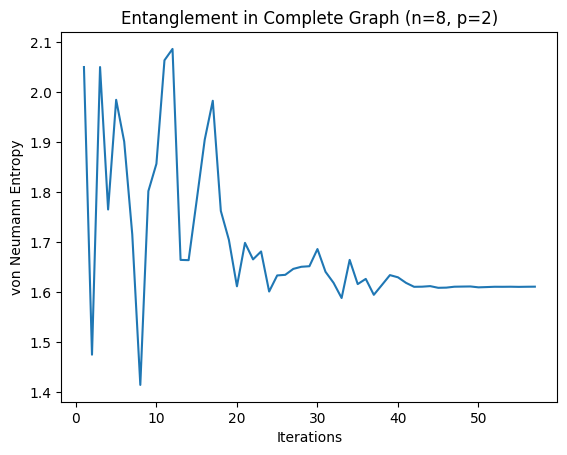

The expectation value of the cut is : 15.44921875.
The solutions are : 00001111, 00010111, 00011011, 00011101, 00011110, 00100111, 00101011, 00101101, 00101110, 00110011, 00110101, 00110110, 00111001, 00111010, 00111100, 01000111, 01001011, 01001101, 01001110, 01010011, 01010101, 01010110, 01011001, 01011010, 01011100, 01100011, 01100101, 01100110, 01101001, 01101010, 01101100, 01110001, 01110010, 01110100, 01111000, 10000111, 10001011, 10001101, 10001110, 10010011, 10010101, 10010110, 10011001, 10011010, 10011100, 10100011, 10100101, 10100110, 10101001, 10101010, 10101100, 10110001, 10110010, 10110100, 10111000, 11000011, 11000101, 11000110, 11001001, 11001010, 11001100, 11010001, 11010010, 11010100, 11011000, 11100001, 11100010, 11100100, 11101000, 11110000 with a MaxCut = 16.
--End of 2 layer analysis--
For a Complete Graph with 8 nodes/qubits and a QAOA circuit with 3 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.0034060506626161.
It ranged from 0.73921649

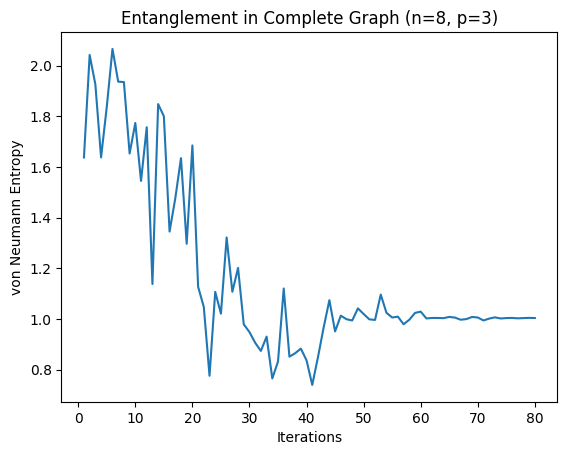

The expectation value of the cut is : 14.7666015625.
The solutions are : 00000111, 00001011, 00001101, 00001110, 00010011, 00010101, 00010110, 00011001, 00011010, 00011100, 00011111, 00100011, 00100101, 00100110, 00101001, 00101010, 00101100, 00101111, 00110001, 00110010, 00110100, 00110111, 00111000, 00111011, 00111101, 00111110, 01000011, 01000101, 01000110, 01001001, 01001010, 01001100, 01001111, 01010001, 01010010, 01010100, 01010111, 01011000, 01011011, 01011101, 01011110, 01100001, 01100010, 01100100, 01100111, 01101000, 01101011, 01101101, 01101110, 01110000, 01110011, 01110101, 01110110, 01111001, 01111010, 01111100, 10000011, 10000101, 10000110, 10001001, 10001010, 10001100, 10001111, 10010001, 10010010, 10010100, 10010111, 10011000, 10011011, 10011101, 10011110, 10100001, 10100010, 10100100, 10100111, 10101000, 10101011, 10101101, 10101110, 10110000, 10110011, 10110101, 10110110, 10111001, 10111010, 10111100, 11000001, 11000010, 11000100, 11000111, 11001000, 11001011, 1100110

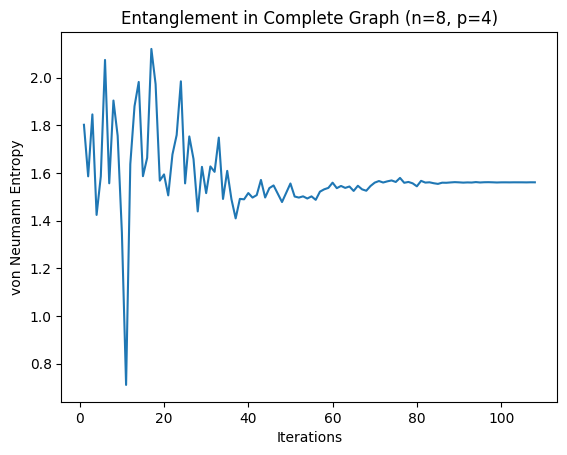

The expectation value of the cut is : 15.3837890625.
The solutions are : 00001111, 00010111, 00011011, 00011101, 00011110, 00100111, 00101011, 00101101, 00101110, 00110011, 00110101, 00110110, 00111001, 00111010, 00111100, 01000111, 01001011, 01001101, 01001110, 01010011, 01010101, 01010110, 01011001, 01011010, 01011100, 01100011, 01100101, 01100110, 01101001, 01101010, 01101100, 01110001, 01110010, 01110100, 01111000, 10000111, 10001011, 10001101, 10001110, 10010011, 10010101, 10010110, 10011001, 10011010, 10011100, 10100011, 10100101, 10100110, 10101001, 10101010, 10101100, 10110001, 10110010, 10110100, 10111000, 11000011, 11000101, 11000110, 11001001, 11001010, 11001100, 11010001, 11010010, 11010100, 11011000, 11100001, 11100010, 11100100, 11101000, 11110000 with a MaxCut = 16.
--End of 4 layer analysis--
For a Complete Graph with 8 nodes/qubits and a QAOA circuit with 5 layers:
The Schmidt number is : 5.
The final von Neumann entropy is : 1.570388212343351.
It ranged from 1.1876229

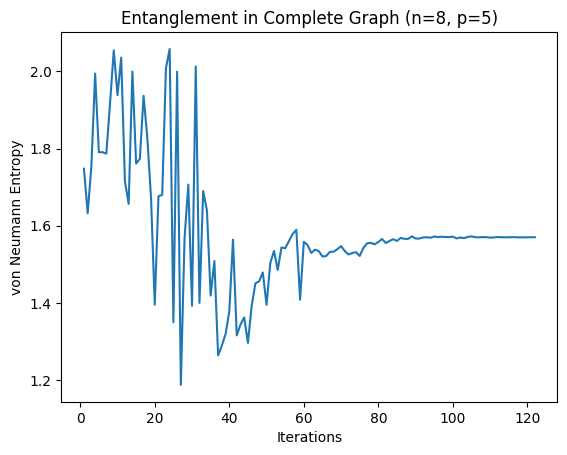

The expectation value of the cut is : 15.5654296875.
The solutions are : 00001111, 00010111, 00011011, 00011101, 00011110, 00100111, 00101011, 00101101, 00101110, 00110011, 00110101, 00110110, 00111001, 00111010, 00111100, 01000111, 01001011, 01001101, 01001110, 01010011, 01010101, 01010110, 01011001, 01011010, 01011100, 01100011, 01100101, 01100110, 01101001, 01101010, 01101100, 01110001, 01110010, 01110100, 01111000, 10000111, 10001011, 10001101, 10001110, 10010011, 10010101, 10010110, 10011001, 10011010, 10011100, 10100011, 10100101, 10100110, 10101001, 10101010, 10101100, 10110001, 10110010, 10110100, 10111000, 11000011, 11000101, 11000110, 11001001, 11001010, 11001100, 11010001, 11010010, 11010100, 11011000, 11100001, 11100010, 11100100, 11101000, 11110000 with a MaxCut = 16.
--End of 5 layer analysis--


In [ ]:
# Optimizing
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from collections import Counter
import random

n_list = [4, 6, 8]
g_list = [0, 1, 2]
graph_name = ['Complete Bipartite Graph', 'Star Graph', 'Complete Graph'] 
p_list = [i for i in range(1, 1 + max(n_list))]

schmidt = 0
vN_Gnp = []
iter_Gnp = []
exp_cut_Gnp = []
opt_cut_Gn = []
    
for i in range(0, len(g_list)):
    #i = 2
    vN_np = []
    iter_np = []
    exp_cut_np = []
    opt_cut_n = []
    
    g = g_list[i]
    g_name = graph_name[i]
    
    for j in range(0, len(n_list)):
        vN_p = []
        iter_p = []
        exp_cut_p = []
        
        n = n_list[j]
        G = graph_maker(n,g)

        expectation = get_expectation(G)

        for k in range(0,len(p_list)):
            vN = []
            iter_num = 0
            
            p = p_list[k]
            theta_seed = [1.0 for i in range(0,2*p)]

            res = minimize(expectation, theta_seed, method='COBYLA')

            iter_list = [(1+i) for i in range(0,iter_num)] #list of iterations for particular G,n,p

            #print(res)
            
            print(f'For a {g_name} with {n} nodes/qubits and a QAOA circuit with {p} layers:')
            print(f'The Schmidt number is : {schmidt}.')

            vN_stat = pd.Series(vN)
            vN_final = vN[-1]
            vN_min = vN_stat.describe().loc['min']
            vN_max = vN_stat.describe().loc['max']
            vN_mean = vN_stat.describe().loc['mean']
            vN_std = vN_stat.describe().loc['std']
            
            vN_prop = [vN_final, vN_min, vN_max, vN_mean, vN_std] #all the properties of vN for particular G,n,p
            
            print(f'The final von Neumann entropy is : {vN_final}.')
            print(f'It ranged from {vN_min} to {vN_max},'
                  f'with a mean of {vN_mean}'
                  f'and a standard deviation of {vN_std}.')
            
            print(f'The initial parameters were : {theta_seed}.')
            print(f'The optimized parameters are : {res.x}.')
            #print(f'The final objective function is : {res.fun}')
            print(f'The total number of iterations required : {res.nfev}.')

            #print(vN)
            #print(iter_list)
            plt.figure()
            plt.plot(iter_list, vN)
            plt.title(f'Entanglement in {g_name} (n={n}, p={p})')
            plt.xlabel('Iterations')
            plt.ylabel('von Neumann Entropy')
            # Show/save figure as desired.
            plt.show()

            #fig, axs = plt.subplots()
            #fig.suptitle(f'{g_name} (n={n}, p=1)')
            #axs.plot(iter_list, vN)
            #axs.set_xlabel('Iterations')
            #axs.set_ylabel('von Neumann Entropy')


            backend = Aer.get_backend('aer_simulator')
            backend.shots = 2048

            qc_res = create_qaoa_circ(G, res.x)

            counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
            
            # Get the counts as a dictionary
            count_dict = dict(counts)

            # Find the count with the maximum frequency
            max_freq = max(count_dict.values())

            # Get a list of all the counts with the maximum frequency
            max_freq_counts = [count for count, freq in count_dict.items() if freq == max_freq]
            #print(max_freq_counts)
            # Choose one of the maximum frequency counts randomly
            mf_count = random.choice(max_freq_counts)
            #print(mf_count)

            
            #mf_count = counts.most_frequent()
            exp_cut = -compute_expectation(counts, G)
            
            %matplotlib inline
            
            plot_histogram(counts, title=f'MaxCut Solutions for {g_name} (n={n}, p={p})').show()
            
            print(f'The expectation value of the cut is : {exp_cut}.')

            filtered_counts = dict(filter(lambda item: (maxcut_obj(item[0][::-1],G) == maxcut_obj(list(str(mf_count))[::-1],G)), counts.items()))

            #filtered_counts = dict(filter(lambda item: (maxcut_obj(item[0][::-1],G) == maxcut_obj(mf_count[::-1],G)), counts.items()))
            maxcounts = list(filtered_counts.keys())
            sortedmax = sorted(maxcounts, key=lambda x: int(x, 2))
            
            opt_cut = -maxcut_obj(maxcounts[0][::-1], G)
            
            

            print(f'The solutions are : {", ".join(sortedmax)} with a MaxCut = {opt_cut}.')
            print(f'--End of {p} layer analysis--')
            
            vN_p.append(vN_prop) #all the properties of vN for particular G,n
            iter_p.append(iter_list) #list of iterations for all p 
            exp_cut_p.append(exp_cut)
        
        plt.figure()
        plt.plot(p_list, exp_cut_p)
        plt.title(f'MaxCut for {g_name} (n={n})')
        plt.xlabel('Depth of QAOA Circuit')
        plt.ylabel('Expected Cut')
        plt.axhline(y=opt_cut,linestyle=':',color='r', label='Optimal Cut')
        leg = plt.legend(loc='upper center')
        # Show/save figure as desired.
        plt.show()
        
        vN_np.append(vN_p) #all the properties of vN for particular G
        iter_np.append(iter_p) #list of iterations for all n,p
        exp_cut_np.append(exp_cut_p)
        opt_cut_n.append(opt_cut)
        
        print(f'--End of {n} qubit analysis--')
        
    vN_Gnp.append(vN_np)
    iter_Gnp.append(iter_np)
    exp_cut_Gnp.append(exp_cut_np)
    opt_cut_Gn.append(opt_cut_n)
    
    print(f'--End of {g_name} analysis--')